In [37]:
import numpy as np
from matplotlib import pyplot as plt

Fonctions de calculs :

In [77]:
def relu():
    return lambda t : max(0,t)
    
def relu_derivee():
    return lambda t : 1 if t > 0 else 0
    
def identite():
    return lambda t : t
    
def identite_derivee():
    return lambda t : 1
    
cout_quadratique = lambda y,prediction: (prediction-y)**2
cout_quadratique_derivee = lambda y,prediction: 2*(prediction-y)

binary_cross_entropy_derivee = lambda y, prediction: (-y/prediction)+ ((1-y)/(1-prediction))
    
def binary_cross_entropy(y, prediction) : 
    sum = 0
    for i in range(0, len(y)):
        sum += y[i]*np.log(prediction[i]) + (1 - y[i]) * np.log(1-predicition[i])  
    return (-1/len(y))* sum

def sigmoid():
    return lambda t : 1 / (1 + np.exp(-t))
    
def sigmoid_derivee():
    sigma = sigmoid()
    return lambda t : sigma(t) * (1-sigma(t))

xor = lambda x : 1 if x[0]*x[1] >= 0 else -1
xorbis = lambda x : 1 if x[0]*x[1] >= 0 else 0

Classe pour notre réseau de neurones contenant toutes les fonctions nécessaires au fonctionnement

In [39]:
class ReseauNeurones:
    
    def __init__(self, taille = 1):
        self.taille = taille
        self.liste_fonctions= None
        self.x = None
        self.y = None
        self.w = []
        self.b = []
        self.liste_fonctions = []
        self.liste_derivees = []
        self.zsave = []
        self.asave = []
        self.prediction = None
        self.gradientw = []
        self.gradientb = []
        fonction_cout = None
        fonction_cout_derivee = None
    
    def set_fonction_cout(self, opti, derivee):
        self.fonction_cout = opti
        self.fonction_cout_derivee = derivee
    
    def ajouter_couche(self, f_activation, derivee_f_activation, nb_neurones = 1):
        self.liste_fonctions.append(f_activation)
        self.liste_derivees.append(derivee_f_activation)
        if(len(self.w)==0):
            self.w.append(np.random.normal(size = (nb_neurones,len(self.x[0]))))
        else:
            self.w.append(np.random.normal(size = (nb_neurones,len(self.w[len(self.w)-1]))))
        self.b.append(np.random.normal(size = (nb_neurones,1)))
        
    def ajouter_couche_manuel(self, f_activation, derivee_f_activation, nb_neurones = 1):
        self.liste_fonctions.append(f_activation)
        self.liste_derivees.append(derivee_f_activation)
        
    def set_data(self, x, y):
        self.x = x
        self.y = y
    
    def propagation_avant(self,vecteur_entree):
        z = []
        a = []
        ztmp=0
        L = len(self.liste_fonctions)
        x=vecteur_entree
        self.asave = []
        self.zsave = []
        self.asave.append(x)
        
        for l in range(0, L): #toutes les couches
            w = self.w[l]
            b = self.b[l]
            n = len(w)
            for nloop in range(0, n): #tous les neurones de chaque couches
                wn = w[nloop]
                bn = b[nloop]
                ztmp = wn.dot(x) + bn[0] #On calcul les différents z
                z.append(ztmp)
                ztmp = self.liste_fonctions[l](ztmp) #f(z)
                a.append(ztmp)
            x = a
            self.asave.append(a)
            self.zsave.append(z)
            a = []
            z = []
        self.prediction = ztmp
        
    def retropropagation(self, nabla_C): 
        L = len(self.liste_fonctions)
        ga = nabla_C
        for l in range(L-1,-1,-1):
            gz = []
            gw = []
            for k in range(0, len(ga)):
                gz.append(ga[k]*self.liste_derivees[l](self.zsave[l][k]))
            al = np.array(self.asave[l]).T
            for i in range(0,len(gz)):
                gwi = gz[i]*al
                gw.append(gwi)
            ga=[]
            ga = self.w[l].T.dot(gz)
            self.gradientb.append(gz)
            self.gradientw.append(gw)
        
    
    def pas_gradient(self, taux_apprentissage):
        
        L = len(self.liste_fonctions)
        gradientw = np.flip(self.gradientw)
        gradientb = np.flip(self.gradientb)
            
        for l in range(0, L):
            for i in range(0, len(self.w[l])):
                self.w[l][i] = self.w[l][i] - taux_apprentissage * gradientw[l][i]
                self.b[l][i] = self.b[l][i] - taux_apprentissage * gradientb[l][i]
    
    def descente_de_gradient(self, iterations,taux_apprentissage):
        k = 0
        vecteur_prediction= np.ones(self.taille)
        while k < iterations :
            if(k % 200 == 0) :
                print("Etapes ",k, " sur ", iterations)
            self.propagation_avant(self.x[k%self.taille])
            self.retropropagation([self.fonction_cout_derivee(self.y[k%self.taille],self.prediction)])
            self.pas_gradient(taux_apprentissage)
            vecteur_prediction[k%self.taille] = self.prediction
            k += 1
        print("Etapes ",k, " sur ", iterations)
        return vecteur_prediction

La fonction ajouter_couche va ajouter la fonction et la fonction dérivée données en argument à la couche en question. Ensuite, elle va initialiser tout les poids avec une loi normale.

La fonction de propagation avant va exécuter les diffèrentes étapes de calculs pour chaque couche de réseau de neurones et pouvoir nous donner la sortie finale de notre réseau.

Ensuite la fonction de rétro propagation va nous permettre de calculer les gradients des poids et les gradients des biais afin de les utiliser dans la descente de pas de gradient pour modifier les poids et les biais.

La descente de gradient va exécuter chacune des fonctions, un certain nombre de fois afin d'approximiser résultat initial au mieux.

# Réseau de neurones pour l'exemple du cours 

In [40]:
rt = ReseauNeurones(2)
a = [[1 , -2]]
a = np.array(a)
print(a)
a.T

rt.w.append(np.array([[0, -1],[ 2, -3],[ 1, -1]]))
rt.w.append(np.array([[ 0,  1,  -1], [ 2, -2, 1]]))
rt.w.append(np.array([[2, -1]]))
rt.b.append(np.array([[0],[ 1],[-1]]))
rt.b.append(np.array([[1],[-2]]))
rt.b.append(np.array([[0]]))

rt.set_data(a[:,0:2],2)

rt.ajouter_couche_manuel(relu(),relu_derivee(),3)
rt.ajouter_couche_manuel(relu(),relu_derivee(),2)
rt.ajouter_couche_manuel(identite(),identite_derivee(),1)
rt.propagation_avant(a[0])
print("Résultat propagation avant : ", rt.asave)
rt.retropropagation([cout_quadratique_derivee(1,rt.prediction)])
print("Résultat rétropropagation : ", rt.gradientw)

[[ 1 -2]]
Résultat propagation avant :  [array([ 1, -2]), [2, 9, 2], [8, 0], [16]]
Résultat rétropropagation :  [[array([240,   0])], [array([120, 540, 120]), array([0, 0, 0])], [array([0, 0]), array([  60, -120]), array([-60, 120])]]


# Entraînement pour la fonction Xor

## Sur 1000 données entre 0 et 1

Initialisation de notre jeu de données donné au réseau de neurones.
Et affichage de ces données.

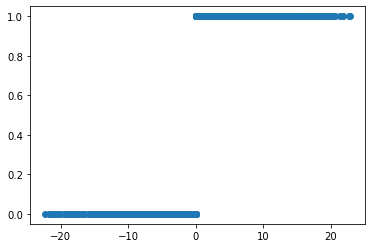

In [78]:
x = np.random.uniform(-5, 5, size=(1000, 2))
y = []
z = []
for i in range(0,1000):
    y.append(xorbis(x[i]))
for i in range(0,1000):
    z.append(x[i][0]*x[i][1])    
plt.scatter(z, y)

Initialisation de notre Réseau de neurones avec 1000 entrées. Nous utiliserons la fonction binary cross entropy pour faire fonctionner notre réseau de neurones.

In [79]:
r = ReseauNeurones(1000)
r.set_fonction_cout(None, binary_cross_entropy_derivee)
r.set_data(x,y)

Ajout des différents couches de notre réseau avec leurs fonctions et le nombre de neurones présents dans chaque couche.
Descente de gradient sur notre jeu de données avec un coefficient $\alpha$ = 0.01.

In [80]:
r.ajouter_couche(sigmoid(),sigmoid_derivee(),500)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),375)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),250)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),125)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),1)

resultat = r.descente_de_gradient(2000, 0.01)

Etapes  0  sur  2000
Etapes  200  sur  2000
Etapes  400  sur  2000
Etapes  600  sur  2000
Etapes  800  sur  2000
Etapes  1000  sur  2000
Etapes  1200  sur  2000
Etapes  1400  sur  2000
Etapes  1600  sur  2000
Etapes  1800  sur  2000
Etapes  2000  sur  2000


On regarde le nombre de données bien classifié par notre réseau de neurones et on en fait une moyenne.

In [81]:
donneesfinales = []
moy = 0
res = 0
for i in range(0, 1000):
    if(y[i]==1):
        res+=1 
for i in range(0, 1000):
    if(resultat[i]>=0.5):
        donneesfinales.append(1)
    else:
        donneesfinales.append(0)
for i in range(0, 1000) : 
    if y[i] == donneesfinales[i]:
        moy += 1
print("Données bien classifiées : ", moy/1000)

Données bien classifiées :  0.985


Données en entrée

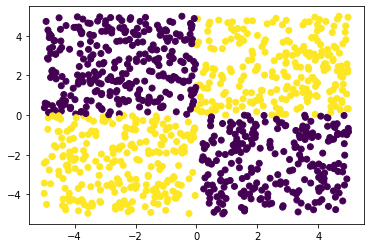

In [59]:
plt.scatter(x[:,0],x[:,1], c = y)

Données en sortie

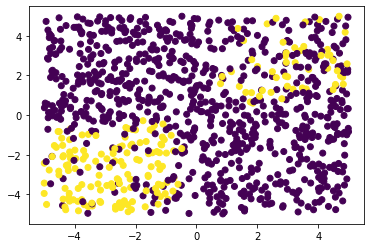

In [60]:
plt.scatter(x[:,0],x[:,1], c = donneesfinales)

## Sur 100 données entre -1 et 1

Initialisation de notre jeu de données donné au réseau de neurones.
Et affichage de ces données.

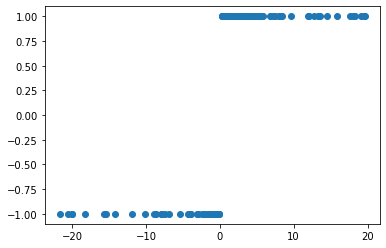

In [41]:
x = np.random.uniform(-5, 5, size=(100, 2))
y = []
z = []
for i in range(0,100):
    y.append(xor(x[i]))
for i in range(0,100):
    z.append(x[i][0]*x[i][1])    
plt.scatter(z, y)

Initialisation de notre Réseau de neurones avec 100 entrées. Nous utiliserons la fonction binary cross entropy pour faire fonctionner notre réseau de neurones.

In [42]:
r = ReseauNeurones(100)
r.set_fonction_cout(None, binary_cross_entropy_derivee)
r.set_data(x,y)

[[ 0.24622035 -3.62165805]
 [-2.76801701 -1.98335761]
 [ 1.9219914   1.75131445]
 [ 3.45627075  0.69038156]
 [ 1.93622522 -0.17290764]
 [ 4.79352108  3.99791599]
 [ 0.06668161 -1.30151022]
 [-1.46779816  1.25989135]
 [ 4.96431423  1.35999225]
 [-3.40445791 -3.97280951]
 [-0.146022    2.9630984 ]
 [-4.41726893 -4.43553783]
 [-0.87883073  4.86695733]
 [ 2.79226073  1.16984622]
 [-4.09524087 -4.3183243 ]
 [-0.47244177 -0.63613535]
 [ 3.96965622  1.75973344]
 [-0.76311969  0.47669049]
 [ 2.41900126 -1.62296412]
 [-2.90973125 -4.363132  ]
 [-2.10663598 -3.94602281]
 [-4.99463165  3.07960321]
 [ 1.37988149 -3.89647503]
 [ 1.79697311 -4.77580321]
 [ 4.13808135  1.92259062]
 [ 1.2135062   3.81772895]
 [-3.28020246 -1.00795648]
 [-1.09501281 -0.86037181]
 [-3.90588932  2.59767693]
 [ 4.51341062  2.95313044]
 [ 4.86589651  3.7723712 ]
 [-4.03601527 -0.17593053]
 [ 1.92160647  4.39601024]
 [-0.43166969  0.57058684]
 [-3.15228298  0.31296634]
 [-4.47499472 -2.68195932]
 [-4.12223014  4.99900053]
 

Ajout des différents couches de notre réseau avec leurs fonctions et le nombre de neurones présents dans chaque couche. 

In [43]:
r.ajouter_couche(sigmoid(),sigmoid_derivee(),100)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),75)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),50)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),25)
r.ajouter_couche(sigmoid(),sigmoid_derivee(),1)

Descente de gradient sur notre jeu de données avec un coefficient $\alpha$ = 0.01.

In [44]:
resultat = r.descente_de_gradient(5000, 0.01)

Etapes  0  sur  5000
Etapes  200  sur  5000
Etapes  400  sur  5000
Etapes  600  sur  5000
Etapes  800  sur  5000
Etapes  1000  sur  5000
Etapes  1200  sur  5000
Etapes  1400  sur  5000
Etapes  1600  sur  5000
Etapes  1800  sur  5000
Etapes  2000  sur  5000
Etapes  2200  sur  5000
Etapes  2400  sur  5000
Etapes  2600  sur  5000
Etapes  2800  sur  5000
Etapes  3000  sur  5000
Etapes  3200  sur  5000
Etapes  3400  sur  5000
Etapes  3600  sur  5000
Etapes  3800  sur  5000
Etapes  4000  sur  5000
Etapes  4200  sur  5000
Etapes  4400  sur  5000
Etapes  4600  sur  5000
Etapes  4800  sur  5000
Etapes  5000  sur  5000


On regarde le nombre de données bien classifié par notre réseau de neurones et on en fait une moyenne.

In [46]:
donneesfinales = []
moy = 0
res = 0
for i in range(0, 100):
    if(y[i]==1):
        res+=1 
for i in range(0, 100):
    if(resultat[i]>=0.5):
        donneesfinales.append(1)
    else:
        donneesfinales.append(-1)
for i in range(0, 100) : 
    if y[i] == donneesfinales[i]:
        moy += 1
print("Données bien classifiées : ", moy/100)

Données bien classifiées :  0.88


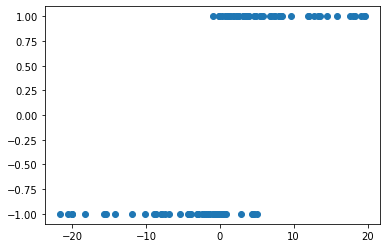

In [47]:
plt.scatter(z, donneesfinales)

Jeu de données en entrée :

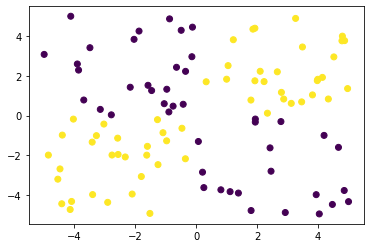

In [48]:
plt.scatter(x[:,0],x[:,1], c = y)

Jeu de données obtenus en sortie : 

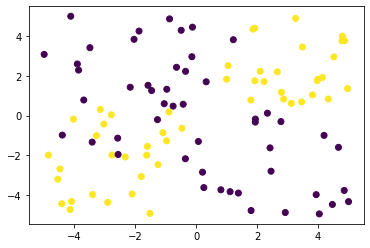

In [49]:
plt.scatter(x[:,0],x[:,1], c = donneesfinales)

# Nouvel exemple sur une droite de 1000 points bruitée

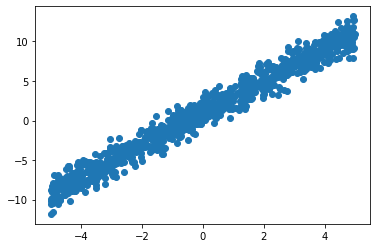

In [65]:
x = np.random.uniform(-5, 5, size=(1000,1))
y = []
a = 2
b = 1
for i in range(0,1000):
    y.append(a*x[i] + b + np.random.randn())
plt.scatter(x, y)

Application du réseau de neurones sur les 1000 points avec comme fonction de coût le cout_quadratique et deux couches de neurones. Une contenant 3 neurones avec comme fonction relu et l'autre avec 1 neurone avec comme fonction identite.
Et exécution de la descente de gradient sur 10000 itérations avec un coefficient $\alpha$ = 0.001

Etapes  0  sur  10000
Etapes  200  sur  10000
Etapes  400  sur  10000
Etapes  600  sur  10000
Etapes  800  sur  10000
Etapes  1000  sur  10000
Etapes  1200  sur  10000
Etapes  1400  sur  10000
Etapes  1600  sur  10000
Etapes  1800  sur  10000
Etapes  2000  sur  10000
Etapes  2200  sur  10000
Etapes  2400  sur  10000
Etapes  2600  sur  10000
Etapes  2800  sur  10000
Etapes  3000  sur  10000
Etapes  3200  sur  10000
Etapes  3400  sur  10000
Etapes  3600  sur  10000
Etapes  3800  sur  10000
Etapes  4000  sur  10000
Etapes  4200  sur  10000
Etapes  4400  sur  10000
Etapes  4600  sur  10000
Etapes  4800  sur  10000
Etapes  5000  sur  10000
Etapes  5200  sur  10000
Etapes  5400  sur  10000
Etapes  5600  sur  10000
Etapes  5800  sur  10000
Etapes  6000  sur  10000
Etapes  6200  sur  10000
Etapes  6400  sur  10000
Etapes  6600  sur  10000
Etapes  6800  sur  10000
Etapes  7000  sur  10000
Etapes  7200  sur  10000
Etapes  7400  sur  10000
Etapes  7600  sur  10000
Etapes  7800  sur  10000
Etapes 

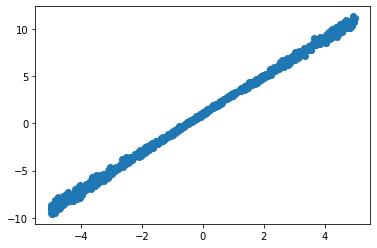

In [66]:
r = ReseauNeurones(1000)
r.set_fonction_cout(cout_quadratique, cout_quadratique_derivee)

r.set_data(x,y)
r.ajouter_couche(relu(),relu_derivee(),3)
r.ajouter_couche(identite(),identite_derivee(),1)
resultat = r.descente_de_gradient(10000, 0.001)
plt.scatter(x, resultat)

On peut remarquer que l'on obtient une courbe qui approxime très bien notre jeu de données donné en entrée.

# Exemple avec coût quadratique

Nouvel exemple sur un jeu de données quadratique :

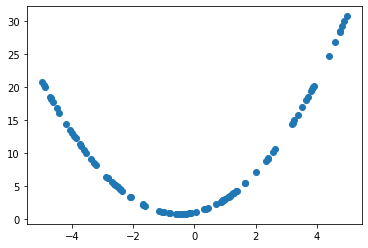

In [67]:
x = np.random.uniform(-5, 5, size=(100,1))
y = []
a = 1
b = 1
c = 1
for i in range(0,100):
    y.append(a*x[i]**2 + b*x[i] + c)
plt.scatter(x, y)

Application d'un réseau de neurones sur les 100 données précédentes avec utilisation du coût quadratique. 
Notre réseau contient 4 couches dont 3 avec la fonction relu et la dernière couche avec la fonction identité.
Notre descente de gradient se fait sur 5000 itérations avec $\alpha$ = 0.0001. 

Etapes  0  sur  5000
Etapes  200  sur  5000
Etapes  400  sur  5000
Etapes  600  sur  5000
Etapes  800  sur  5000
Etapes  1000  sur  5000
Etapes  1200  sur  5000
Etapes  1400  sur  5000
Etapes  1600  sur  5000
Etapes  1800  sur  5000
Etapes  2000  sur  5000
Etapes  2200  sur  5000
Etapes  2400  sur  5000
Etapes  2600  sur  5000
Etapes  2800  sur  5000
Etapes  3000  sur  5000
Etapes  3200  sur  5000
Etapes  3400  sur  5000
Etapes  3600  sur  5000
Etapes  3800  sur  5000
Etapes  4000  sur  5000
Etapes  4200  sur  5000
Etapes  4400  sur  5000
Etapes  4600  sur  5000
Etapes  4800  sur  5000
Etapes  5000  sur  5000


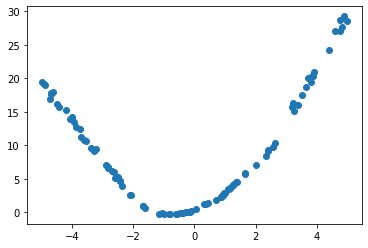

In [68]:
r = ReseauNeurones(100)
r.set_fonction_cout(cout_quadratique, cout_quadratique_derivee)

r.set_data(x,y)
r.ajouter_couche(relu(),relu_derivee(),18)
r.ajouter_couche(relu(),relu_derivee(),9)
r.ajouter_couche(relu(),relu_derivee(),3)
r.ajouter_couche(identite(),identite_derivee(),1)
resultat = r.descente_de_gradient(5000, 0.0001)
plt.scatter(x, resultat)

Prédiction d'un point dans notre modèle

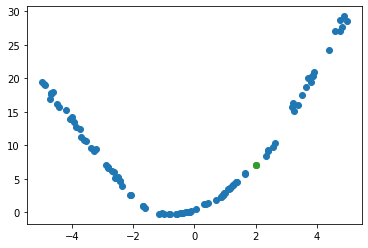

In [69]:
xe = 2
ye = a*xe**2 + b*xe + c
plt.scatter(x, resultat)
plt.scatter(xe,ye)
test = []
test.append(xe)
r.propagation_avant(test)
plt.scatter(xe, r.prediction)